# Interacting with CLIP 

Adapted from the notebook https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

### Install pytorch and these prereqs

In [116]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [2]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

#assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.8.1


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [102]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [18]:
!ls location_descriptions

fight_rat.png                         standing_in_a_room_on_tiled_floor.png
fight_squirtle.png                    walking_around_town.png
meeting_inside_oaks_office.png        walking_in_tall_grass.png


In [109]:
descriptions = {}
img_loc = 'location_descriptions'
for path in os.listdir(img_loc):
    if path[-4:] == '.png':
        descriptions[path] = path[:-4].replace('_', ' ')
    
descriptions

{'fight_squirtle.png': 'fight squirtle',
 'walking_around_town.png': 'walking around town',
 'standing_in_a_room_on_tiled_floor.png': 'standing in a room on tiled floor',
 'walking_in_tall_grass.png': 'walking in tall grass',
 'fight_rat.png': 'fight rat',
 'meeting_inside_oaks_office.png': 'meeting inside oaks office'}

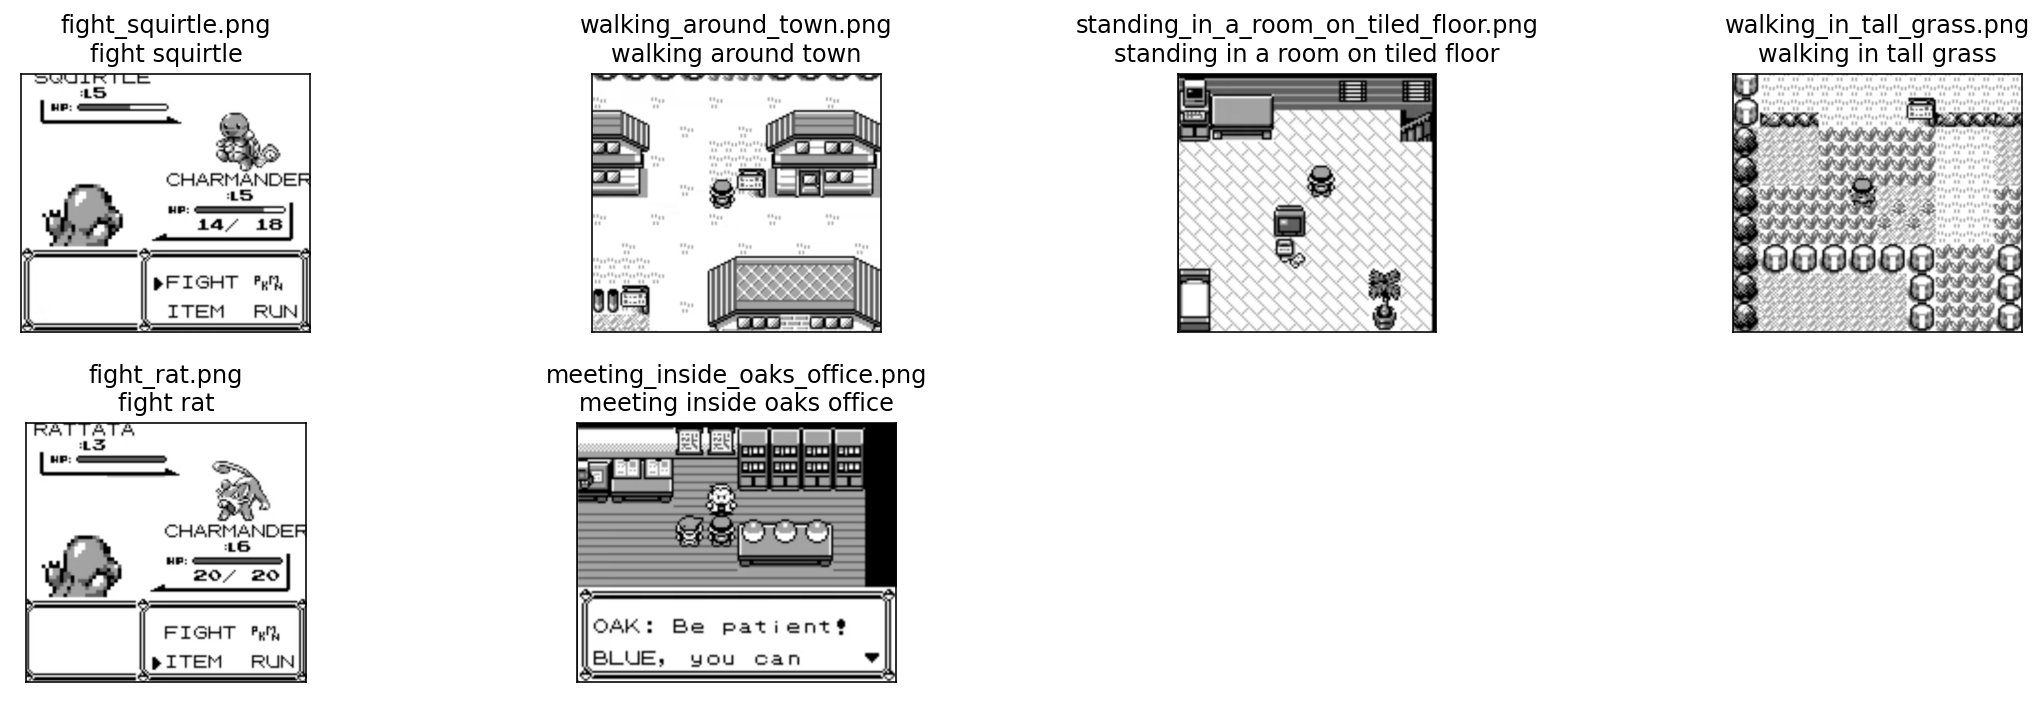

In [110]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename, desc in descriptions.items():
    name = filename

    image = Image.open(os.path.join(img_loc, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [111]:
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["black and white pixel art " + desc for desc in texts])

In [112]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [113]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

clip accuracy: 0.833 random guess: 0.167


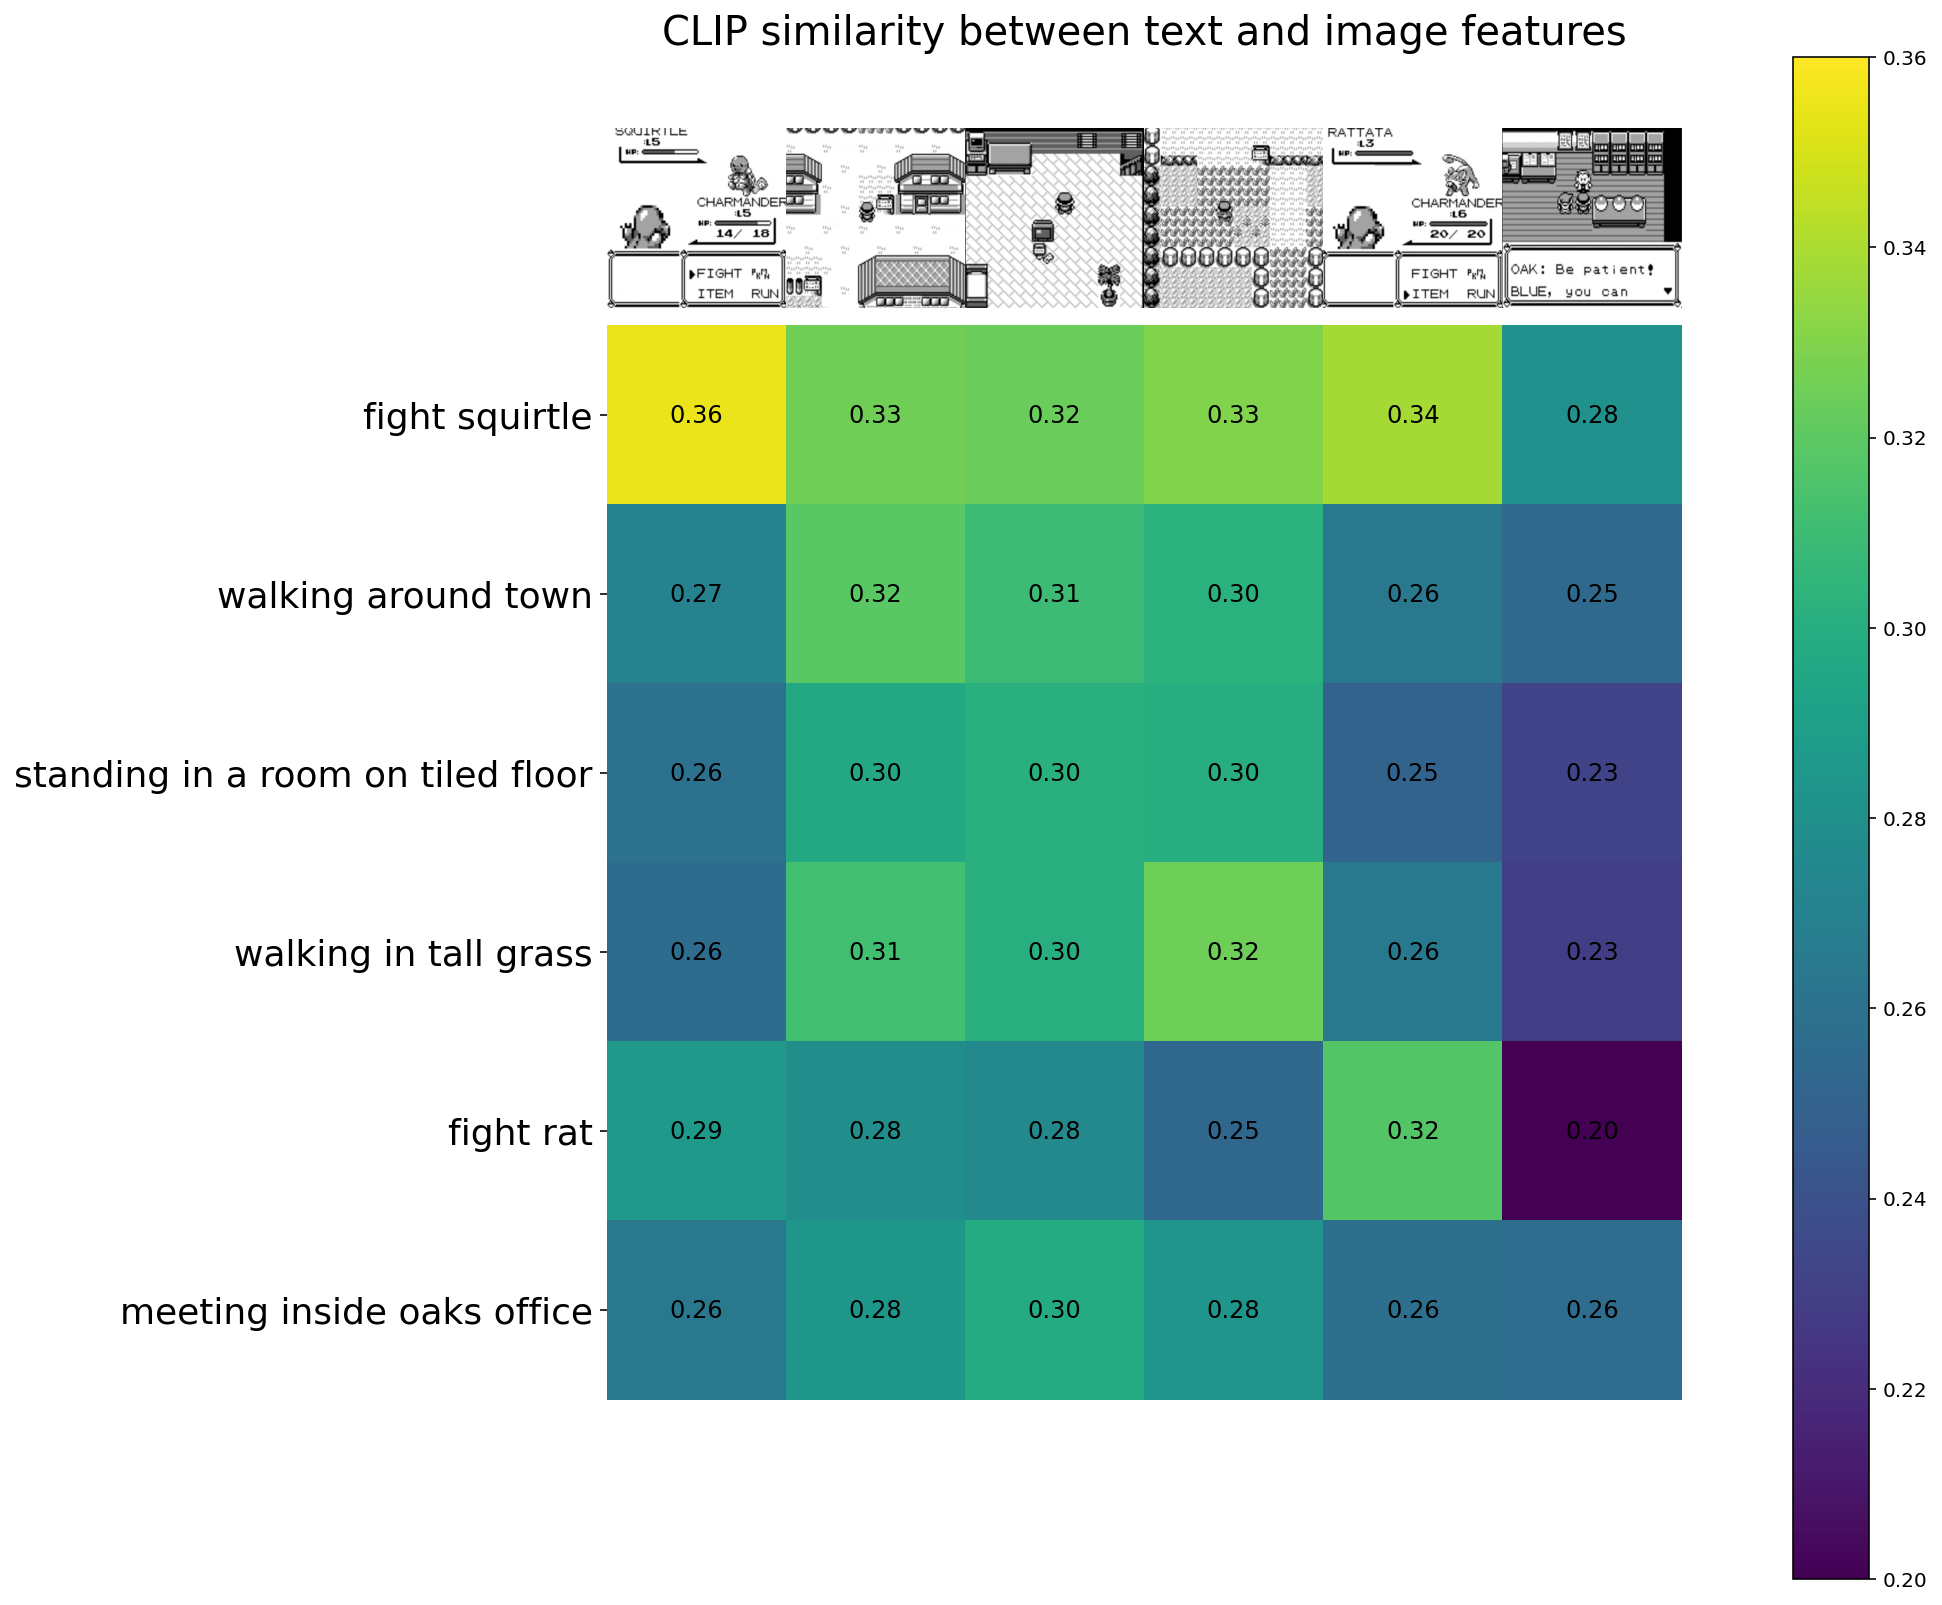

In [115]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.2, vmax=0.36)
plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("CLIP similarity between text and image features", size=20)

predictions = similarity.argmax(axis=1)
count = len(predictions)
accuracy = ((predictions - np.arange(count)) == 0).sum()/count
random_guess = 1/count
print(f'clip accuracy: {accuracy:.3f} random guess: {random_guess:.3f}')